#Install Kaggle for Dataset Download

In [1]:
!pip install kaggle

#Import Packages

In [3]:
import os
import numpy as np
import pandas as pd
import random
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#Download Dataset

In [4]:
# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 93% 14.0M/15.1M [00:00<00:00, 66.4MB/s]
100% 15.1M/15.1M [00:00<00:00, 64.8MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: data/brain_tumor_dataset/no/10 no.jpg  
  inflating: data/brain_tumor_dataset/no/11 no.jpg  
  inflating: data/brain_tumor_dataset/no/12 no.jpg  
  inflating: data/brain_tumor_dataset/no/13 no.jpg  
  inflating: data/brain_tumor_dataset/no/14 no.jpg  
  inflating: data/brain_tumor_dataset/no/15 no.jpg  
  inflating: data/brain_tumor_dataset/no/17 no.jpg  
  inflating: data/brain_tumor_dataset/no/18 no.jpg  
  inflating: data/brain_tumor_dataset/no/19 no.jpg  
  inflating: data/brain_tumor_dataset/no/2 no.jpeg  
  inflating: data/brain_tumor_dataset/no/20 no.jpg  
  inflating: data/brain_tumor_dataset/no/21 no.jpg  
  inflating: data/brain_tumor_dataset/no/22 n

In [5]:
# Set data paths
data_dir = 'data/brain_tumor_dataset'
categories = ['yes', 'no']

In [6]:
# Initialize lists to hold the images and labels
tumor = []
healthy = []

# Load tumor images
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

# Load healthy images
for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [7]:
# Convert lists to numpy arrays
tumor = np.array(tumor)
healthy = np.array(healthy)
All = np.concatenate((healthy, tumor))

In [8]:
healthy.shape

(85, 128, 128, 3)

In [9]:
tumor.shape

(86, 128, 128, 3)

In [10]:
np.random.choice(10, 5, replace=False)

array([4, 9, 3, 6, 7])

#Visualize the MRI Dataset

In [11]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

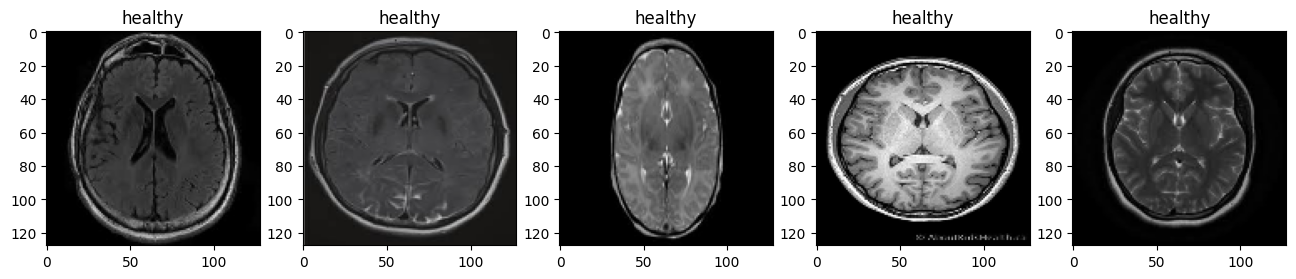

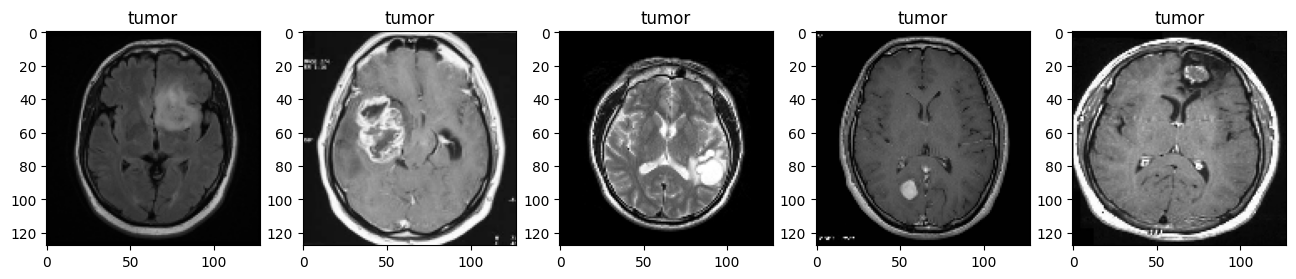

In [12]:
plot_random(healthy, tumor, num=5)

#Process the Dataset

In [13]:
# Create labels
tumor_labels = np.ones(len(tumor))
healthy_labels = np.zeros(len(healthy))

In [14]:
# Combine the data and labels
X = np.concatenate((tumor, healthy), axis=0)
y = np.concatenate((tumor_labels, healthy_labels), axis=0)

In [15]:
# Normalize the data
X = X / 255.0

In [16]:
# Convert labels to categorical
y = to_categorical(y, num_classes=2)

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Design a U-Net Model

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout
from tensorflow.keras.models import Model

In [27]:
def unet_model_for_classification(input_shape, num_classes, dropout_rate=0.5):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(dropout_rate)(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(dropout_rate)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(dropout_rate)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # Classification head
    f = Flatten()(c7)
    outputs = Dense(num_classes, activation='softmax')(f)

    model = Model(inputs, outputs)
    return model

# The 'categories' has been defined and it contains the class labels
input_shape = (128, 128, 3)
num_classes = len(categories)
dropout_rate = 0.5  # Hyperparameter

# Create the model
model = unet_model_for_classification(input_shape, num_classes, dropout_rate)

In [28]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the Model

In [29]:
# Hyperparameters
batch_size = 32
epochs = 25

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/25
5/5 [==============================] - 80s 15s/step - loss: 3.9675 - accuracy: 0.4926 - val_loss: 0.6976 - val_accuracy: 0.4857
Epoch 2/25
5/5 [==============================] - 78s 16s/step - loss: 0.8085 - accuracy: 0.5074 - val_loss: 0.6925 - val_accuracy: 0.5143
Epoch 3/25
5/5 [==============================] - 72s 14s/step - loss: 0.7045 - accuracy: 0.4926 - val_loss: 0.6933 - val_accuracy: 0.5143
Epoch 4/25
5/5 [==============================] - 71s 14s/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5143
Epoch 5/25
5/5 [==============================] - 74s 15s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5143
Epoch 6/25
5/5 [==============================] - 71s 14s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5143
Epoch 7/25
5/5 [==============================] - 72s 14s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5143
Epoch 8/25
5/5 [===========

#Evaluate the Model

In [30]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 4s 302ms/step - loss: 0.6404 - accuracy: 0.6286
Test Loss: 0.6403570175170898
Test Accuracy: 0.6285714507102966


#Visualize the Training History

In [31]:
import matplotlib.pyplot as plt

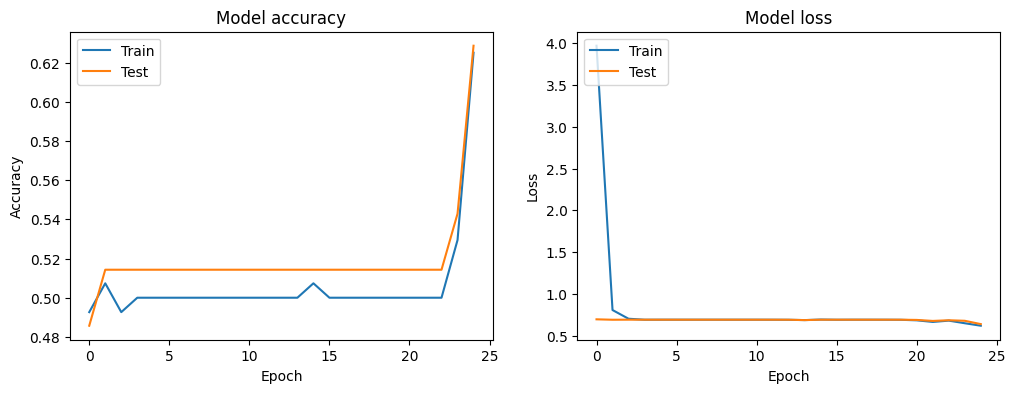

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction and Evaluate using Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 4s 502ms/step


<Figure size 800x600 with 0 Axes>

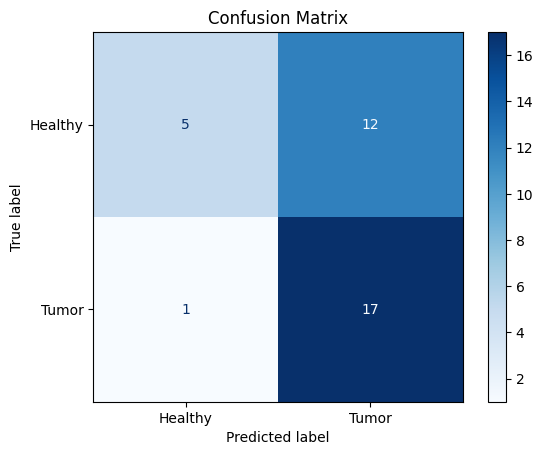

In [35]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

#Retrain the Model using 64 batch size and 40 of ephocs

In [36]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Hyperparameters
batch_size = 64
epochs = 40

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/40
3/3 [==============================] - 78s 20s/step - loss: 0.5400 - accuracy: 0.7132 - val_loss: 0.6223 - val_accuracy: 0.6571
Epoch 2/40
3/3 [==============================] - 72s 20s/step - loss: 0.5364 - accuracy: 0.7500 - val_loss: 0.6399 - val_accuracy: 0.6857
Epoch 3/40
3/3 [==============================] - 77s 23s/step - loss: 0.5156 - accuracy: 0.7647 - val_loss: 0.6207 - val_accuracy: 0.6857
Epoch 4/40
3/3 [==============================] - 70s 20s/step - loss: 0.4949 - accuracy: 0.7941 - val_loss: 0.6225 - val_accuracy: 0.6857
Epoch 5/40
3/3 [==============================] - 75s 22s/step - loss: 0.4867 - accuracy: 0.7941 - val_loss: 0.6025 - val_accuracy: 0.6571
Epoch 6/40
3/3 [==============================] - 70s 20s/step - loss: 0.4344 - accuracy: 0.8015 - val_loss: 0.5875 - val_accuracy: 0.6571
Epoch 7/40
3/3 [==============================] - 72s 21s/step - loss: 0.3828 - accuracy: 0.7941 - val_loss: 0.5699 - val_accuracy: 0.7143
Epoch 8/40
3/3 [===========

#Evaluate the Model

In [38]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 7s 281ms/step - loss: 1.6932 - accuracy: 0.7714
Test Loss: 1.6932196617126465
Test Accuracy: 0.7714285850524902


#Visualize the Training History

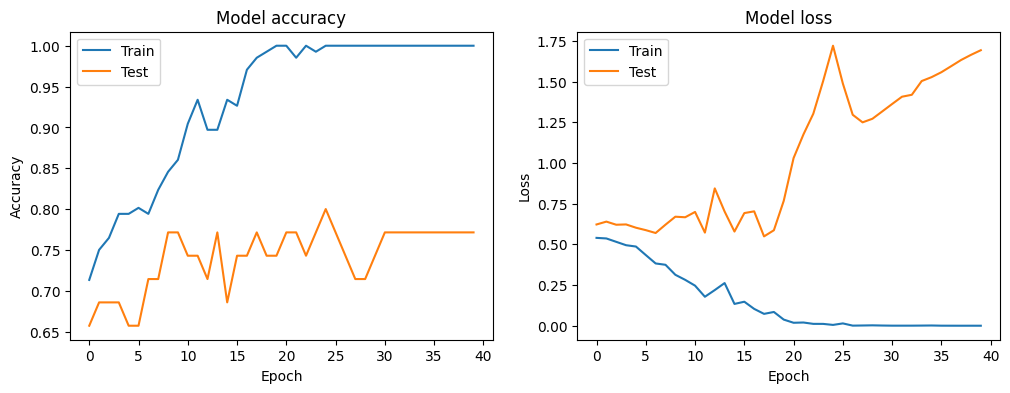

In [39]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction and Evaluate using Confusion Matrix

In [40]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 4s 288ms/step


<Figure size 800x600 with 0 Axes>

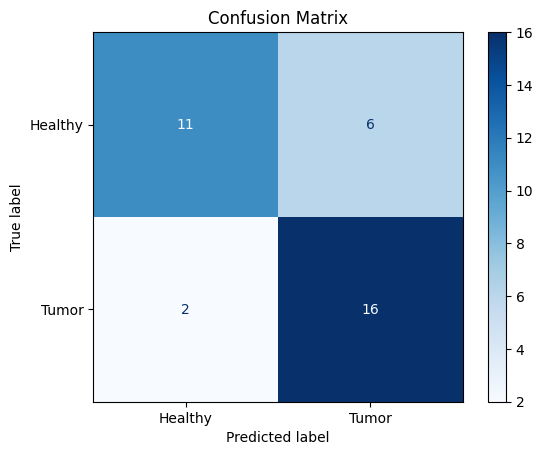

In [41]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

#Retrain the Model using 16 batch size and 50 of ephocs

In [42]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# Hyperparameters
batch_size = 16
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
9/9 [==============================] - 71s 7s/step - loss: 0.0337 - accuracy: 0.9853 - val_loss: 1.1941 - val_accuracy: 0.8000
Epoch 2/50
9/9 [==============================] - 64s 7s/step - loss: 0.0269 - accuracy: 0.9926 - val_loss: 1.2982 - val_accuracy: 0.7429
Epoch 3/50
9/9 [==============================] - 64s 7s/step - loss: 0.0224 - accuracy: 0.9853 - val_loss: 1.3679 - val_accuracy: 0.7714
Epoch 4/50
9/9 [==============================] - 67s 8s/step - loss: 0.0134 - accuracy: 1.0000 - val_loss: 1.3159 - val_accuracy: 0.7714
Epoch 5/50
9/9 [==============================] - 65s 7s/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.5124 - val_accuracy: 0.7714
Epoch 6/50
9/9 [==============================] - 66s 7s/step - loss: 4.2756e-04 - accuracy: 1.0000 - val_loss: 1.5948 - val_accuracy: 0.7429
Epoch 7/50
9/9 [==============================] - 67s 7s/step - loss: 1.7206e-04 - accuracy: 1.0000 - val_loss: 1.7131 - val_accuracy: 0.7714
Epoch 8/50
9/9 [==========

#Evaluate the Model

In [44]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 4s 297ms/step - loss: 2.2806 - accuracy: 0.7714
Test Loss: 2.2806291580200195
Test Accuracy: 0.7714285850524902


#Visualize the Training History

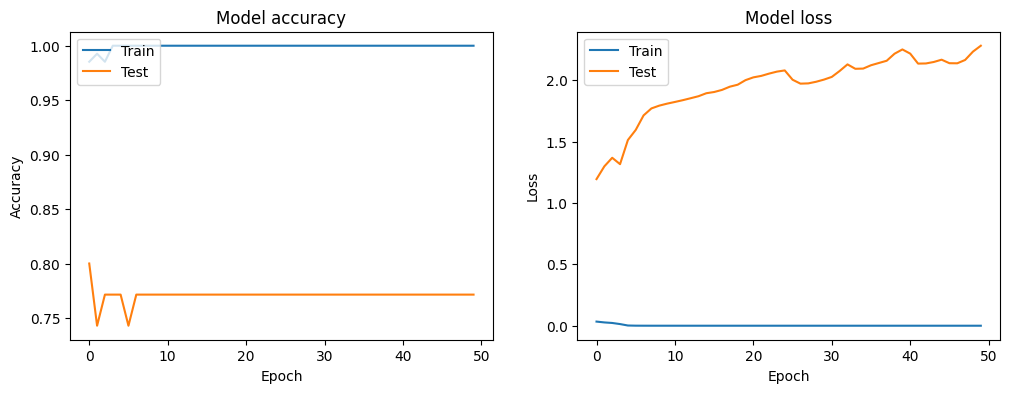

In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction

In [46]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 6s 525ms/step


<Figure size 800x600 with 0 Axes>

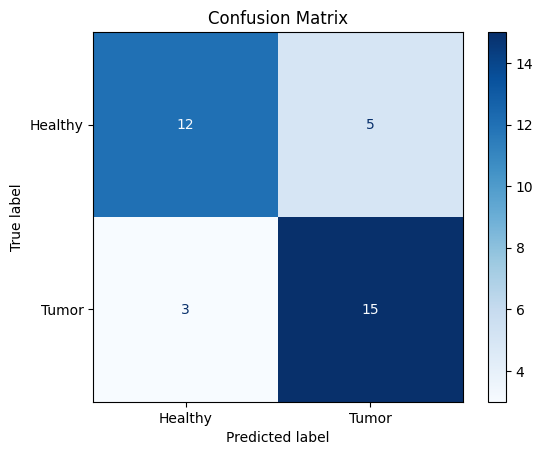

In [47]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()